# Motivation

In a traditional RNN, the hidden state $h_t$ is updated at a time $t$ as

$$h_t = \sigma\left(Wx_t + Uh_{t-1} + b\right)$$
Where $x_t \in \mathcal{R}^n$ is the input at time $t$, $h_{t-1} \in \mathcal{R}^\ell$ is the previous hidden state, and $W \in \mathcal{R}^{\ell \times n}, U \in \mathcal{R}^{\ell \times \ell}, b \in \mathcal{R}^\ell$ are all learned parameters, and $\sigma$ is a nonlinear activation function. The $j$th output neuron of this can be represented as:

$$h_{j,t} = \sigma\left((Wx_t)_j + (Uh_{t-1})_j + b_j\right) = \sigma\left(b_j + \sum_{i=1}^{n}{W_{ji}x_{i,t}} + \sum_{i=1}^{\ell}{U_{ji}h_{i,t-1}}\right)$$

As can be seen above, there is a neuronal connection between the neurons $h_{j,t}$ and $h_{i,t-1}$ for all $i=1,\ldots,\ell$. The authors argue that this can cause exploding/vanishing gradients, and instead allow only the connections between $h_{j,t}$ and $h_{j,t-1}$, as:

$$h_{j,t} = \sigma\left(b_j + u_{j}h_{j,t-1} + \sum_{i=1}^{n}{W_{ji}x_{i,t}}\right)$$

This corresponds to replacing the linear transformation $U$ with a vector $u$ to be instead multiplied element-wise with $h_{t-1}$. Alternatively, this can be represented by a diagonal matrix $\text{diag}(u) = \begin{pmatrix}u_1 & \ldots & 0 \\ 0 & \ddots & 0 \\ 0 & \ldots & u_n\end{pmatrix}$:

$$h_t = \sigma\left(Wx_t + u\odot h_{t-1} + b\right) = \sigma\left(Wx_t + \text{diag}(u)h_{t-1} + b\right)$$

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import keras
import keras.backend as K

Using TensorFlow backend.


# Define a class `IndRNNCell` representing the transformation $(x_t, h_{t-1}) \mapsto h_t$ that can layer be wrapped in a `keras.layers.RNN` object.

In [0]:
import numpy as np
class IndRNNCell(keras.layers.Layer):
    def __init__(self,
                 units,
                 kernel_initializer='glorot_uniform',
                 recurrent_kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 recurrent_clip=1,
                 activation='relu',
                 **kwargs):
        self.units = units
        self.state_size = units
        self.kernel_initializer = kernel_initializer
        self.recurrent_kernel_initializer = recurrent_kernel_initializer
        self.bias_initializer = bias_initializer
        self.recurrent_clip = recurrent_clip
        self.activation = keras.layers.Activation(activation)
        super(IndRNNCell, self).__init__(**kwargs)
    
    def compute_output_shape(input_shape):
        return (input_shape[0], self.units)
    
    def build(self, input_shape, **kwargs):
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[-1], self.units),
                                      initializer=self.kernel_initializer)
        self.recurrent_kernel = self.add_weight(name='recurrent_kernel',
                                                shape=(self.units,),
                                                initializer=self.recurrent_kernel_initializer)
        sgn = K.sign(self.recurrent_kernel)
        self.recurrent_kernel = K.clip(K.abs(self.recurrent_kernel), 0, self.recurrent_clip) * sgn
        self.bias = self.add_weight(name='bias',
                                    shape=(self.units,),
                                    initializer=self.bias_initializer)
        super(IndRNNCell, self).build(input_shape, **kwargs)
    
    def call(self, inputs, states):
        prev_state = states[0]
        h = K.dot(inputs, self.kernel)
        h = h + prev_state * self.recurrent_kernel
        h = h + self.bias
        h = self.activation(h)
        return h, [h]

In [4]:
!git clone https://github.com/wtaylor17/keras-vpnn.git
import sys
sys.path.append('keras-vpnn')

Cloning into 'keras-vpnn'...
remote: Enumerating objects: 129, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 129 (delta 72), reused 92 (delta 40), pack-reused 0
Receiving objects: 100% (129/129), 21.38 KiB | 5.34 MiB/s, done.
Resolving deltas: 100% (72/72), done.


The paper recommends we restrict $|u_j| \in [0, 2^{1/T}]$. Let's do that too and test on the adding problem with $T = 100, \ell = 128$.

In [14]:
from vpnn.utils import adding_problem_generator
from keras.optimizers import Adam
lr = 0.0002
batch_size = 128
steps_per_epoch = 50
epochs = 100
decay = lr / (steps_per_epoch * epochs)
time_steps = 100
n_layers = 2
clip_val = 2 ** (1 / time_steps)
gen = adding_problem_generator(time_steps=time_steps, batch_size=batch_size)

inp = keras.layers.Input((time_steps, 2))
rnn = keras.layers.RNN(IndRNNCell(128, activation='relu',
                                  recurrent_clip=clip_val),
                       return_sequences=True)(inp)
rnn = keras.layers.RNN(IndRNNCell(128, activation='relu',
                                  recurrent_clip=clip_val))(rnn)
dense = keras.layers.Dense(1, activation=None)(rnn)

model = keras.models.Model(inp, dense)

model.compile(loss='mse', optimizer=Adam(lr=lr, amsgrad=True, decay=decay))

history = model.fit_generator(gen(),
                              epochs=epochs,
                              steps_per_epoch=steps_per_epoch).history

Epoch 1/100
50/50 [==============================] - 10s 197ms/step - loss: 0.8770
Epoch 2/100
50/50 [==============================] - 9s 186ms/step - loss: 0.3467
Epoch 3/100
50/50 [==============================] - 9s 186ms/step - loss: 0.1822
Epoch 4/100
50/50 [==============================] - 9s 186ms/step - loss: 0.1773
Epoch 5/100
50/50 [==============================] - 9s 185ms/step - loss: 0.1699
Epoch 6/100
50/50 [==============================] - 9s 184ms/step - loss: 0.1653
Epoch 7/100
50/50 [==============================] - 9s 185ms/step - loss: 0.1693
Epoch 8/100
50/50 [==============================] - 9s 185ms/step - loss: 0.1702
Epoch 9/100
50/50 [==============================] - 9s 185ms/step - loss: 0.1710
Epoch 10/100
50/50 [==============================] - 9s 184ms/step - loss: 0.1685
Epoch 11/100
50/50 [==============================] - 9s 186ms/step - loss: 0.1696
Epoch 12/100
50/50 [==============================] - 9s 184ms/step - loss: 0.1667
Epoch 13/100

# Let's look at the loss!

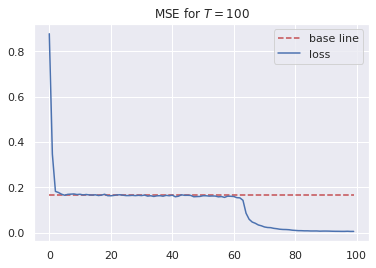

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

baseline = [0.167] * epochs
plt.plot(baseline, 'r--', label='base line')
plt.plot(history['loss'], label='loss')
plt.legend()
plt.title(r'MSE for $T=100$')
plt.show()